In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score
from sklearn import metrics

In [2]:
df_cct = pd.read_parquet("/home/onyxia/work/df_all.parquet")

In [3]:
# Pour "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [5]:
df_cct.columns

Index(['User', 'Card', 'Month', 'Day', 'Hours', 'Amount', 'Use Chip',
       'Card Brand', 'Card Type', 'Credit Limit', 'year_diff', 'delta_t_s',
       'delta_t_s_card', 'day_of_week', 'amt/daily_income', 'Retired',
       'daily_amount', 'nb_daily_declines_card', 'nb_weekly_declines_card',
       'nb_monthly_declines_card', 'bad_pin', 'insufficient_balance',
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt', 'Is Fraud?', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction'],
      dtype='object')

In [6]:
df_cct = df_cct[['Month', 'Day', 'Hours', 'Amount', 
       'Credit Limit', 'year_diff', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt',
       'Online Transaction', 'Swipe Transaction', 'Is Fraud?',]]

### Correlation map

<Axes: >

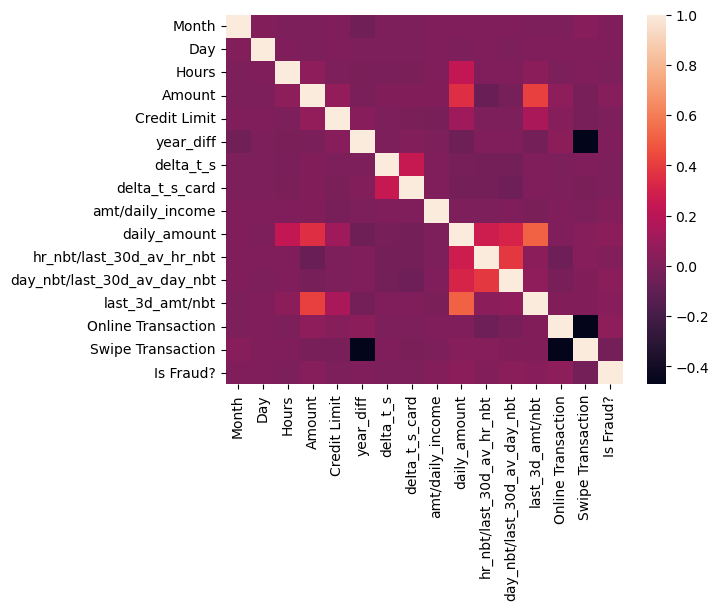

In [7]:
sns.heatmap(df_cct.corr())

### Preprocessing

In [8]:
# selecting features
features = ['Month', 'Day', 'Hours', 'Amount', 
       'Credit Limit', 'year_diff', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt',
       'Online Transaction', 'Swipe Transaction']
X = df_cct[features]
y = df_cct["Is Fraud?"]

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# using Column Transformer for RobustScaler (numerical values) and OneHotEncoder (categorical values)
preprocessor = ColumnTransformer(
        remainder='passthrough', #passthough features not listed
        transformers=[
            ('rbscaler', RobustScaler(), ['Month', 'Day', 'Hours', 'Amount', 
       'Credit Limit', 'year_diff', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income',
       'daily_amount', 
       'hr_nbt/last_30d_av_hr_nbt', 'day_nbt/last_30d_av_day_nbt',
       'last_3d_amt/nbt'])
       ])
X = preprocessor.fit_transform(X)

In [10]:
# splitting train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)


### Modeling

In [11]:
# Build and train model
decision_tree = DecisionTreeClassifier(class_weight = "balanced")
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced')

In [16]:
# Apply model to validation data
y_pred = decision_tree.predict(X_test)

### Evaluating

In [17]:
# Evaluate model
print('Classification metrics: \n', classification_report(y_test, y_pred))

Classification metrics: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   7307143
           1       0.11      0.11      0.11      8927

    accuracy                           1.00   7316070
   macro avg       0.56      0.55      0.55   7316070
weighted avg       1.00      1.00      1.00   7316070



In [18]:
# plot confusion matrix function
import itertools

def plot_confusion_matrix(cm,normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        classes=['Non-Fraud','Fraud']
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=0)
        plt.yticks(tick_marks, classes)
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            # print("Normalized confusion matrix")
        else:
            1  # print('Confusion matrix, without normalization')

        # print(cm)

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return ()

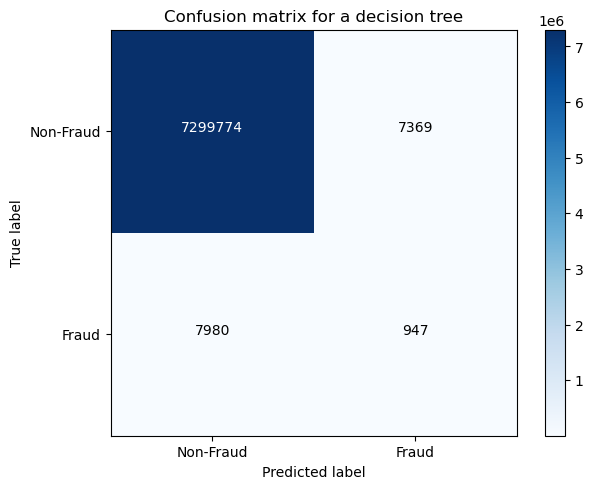

In [19]:

cnf_matrix_dtree = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix_dtree, title='Confusion matrix for a decision tree')
plt.show()

In [21]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred, labels=[0,1]).ravel()
cost = fp*15 + fn*45 - tp*45
cost

427020

In [24]:
df_score = pd.DataFrame(data = {"model" : "dtc_less_var_balanced", "accuracy_score" : accuracy_score(y_test,y_pred),
"precision_score" : precision_score(y_test,y_pred), "recall_score" : recall_score(y_test,y_pred),
"f1_score" : f1_score(y_test,y_pred), "cost (in euros)" : cost}, index=[0])

In [25]:
df_score.loc[0]

model              dtc_less_var_balanced
accuracy_score                  0.997902
precision_score                 0.113877
recall_score                    0.106083
f1_score                        0.109842
cost (in euros)                   427020
Name: 0, dtype: object

### RandomizedSearchCV

In [20]:
from sklearn.model_selection import RandomizedSearchCV
weights = np.linspace(0.01, 0.2, 3)
param_grid = {'class_weight' : [{0: x, 1: 1.0-x} for x in weights],
              'max_depth' : [5, 10, 15, 20],
              'criterion' : ['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=42)
grid_search = RandomizedSearchCV(estimator=tree_clas, param_distributions=param_grid, cv=3, verbose=True, scoring="f1")
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


KeyboardInterrupt: 